In [25]:
import numpy as np

import os
import h5py

from scipy import signal
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split

from datetime import timedelta
#from obspy import UTCDateTime, Catalog, read
#from obspy.clients.fdsn import Client
#from obspy.taup import TauPyModel


from skimage.metrics import structural_similarity as sim

from models.N2N_Unet import N2N_Unet_DAS, N2N_Orig_Unet, Cut2Self, U_Net_origi, U_Net, TestNet
from metric import Metric
from masks import Mask
from models.P_Unet import P_U_Net
from utils import *
from transformations import *
from loss import calculate_loss
import config as config

In [26]:
def get_test_samples():
    
    test_path = '../../data/earthquakes/sissle/eq_data_50Hz/test/'
    test_paths = sorted([test_path + f for f in os.listdir(test_path)])

    indices = [6250,6750,6250,5250,7500,5500]
    test_data = []
    for i, (p, idx) in enumerate(zip(test_paths, indices)):
        with h5py.File(p, 'r') as hf:
            test_data.append(hf['DAS'][81:,idx-3000:idx+3000])
    test_data = np.stack(test_data)[[2,3,5,0,1,4]]

    gutter = 1000
    test_data = np.pad(test_data, ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    test_data = bandpass(test_data, low=1.0, high=10.0, fs=50, gutter=gutter)
    test_scale = test_data.std(axis=-1, keepdims=True)


    test_data = torch.from_numpy(test_data.copy())
    test_scale = torch.from_numpy(test_scale.copy())
    
    return test_data, test_scale

def bandpass(x, low, high, fs, gutter, alpha=0.1):
    """
    alpha: taper length
    """
    
    passband = [2 * low/fs, 2 * high/fs]
    b, a = signal.butter(2, passband, btype="bandpass")
    window = signal.windows.tukey(x.shape[-1], alpha=alpha)
    x = signal.filtfilt(b, a, x * window, axis=-1)

    return x[..., gutter:-gutter]

def generate_synthetic_das(strain_rate, gauge, fs, slowness, nx=512):

    # shift
    # slowness: 0.0001 s/m = 0.1 s/km   -  0.005 s/m = 5 s/km
    # speed: 10,000 m/s = 10 km/s    -  200 m/s = 0.2 km/s
    shift = gauge * fs * slowness # L f / v

    sample = torch.zeros((nx, len(strain_rate)))
    for i in range(nx):
        sample[i] = torch.roll(strain_rate, int(i*shift + np.random.randn(1)))
    
    return sample

def shift_traffic_rates(traffic_rates, gauge, fs, slowness):

    # shift
    # slowness: 0.0001 s/m = 0.1 s/km   -  0.005 s/m = 5 s/km
    # speed: 10,000 m/s = 10 km/s    -  200 m/s = 0.2 km/s
    shift = gauge * fs * slowness # L f / v
    
    # traffic_rates shape (512,3000)
    traffic_rates = torch.tile(traffic_rates, (1,3))
    sample = torch.zeros_like(traffic_rates)
    for i in range(len(traffic_rates)):
        sample[i] = torch.roll(traffic_rates[i], int(i*shift + np.random.randn(1)))
    sample = torch.roll(sample, np.random.randint(0,traffic_rates.shape[1]//3))

    return sample

class SyntheticTrafficDAS(Dataset):
    def __init__(self, eq_strain_rates, traffic_inc, traffic_dec, 
                 nx=64, nt=256, eq_slowness=(1e-4, 5e-3), log_SNR=(-2,4), traffic_slowness=(3e-2, 6e-2),
                 gauge=4, fs=50.0, size=1000):
        self.eq_strain_rates = eq_strain_rates / eq_strain_rates.std(dim=-1, keepdim=True)
        self.traffic_inc = traffic_inc / traffic_inc.std(dim=-1, keepdim=True)
        self.traffic_dec = traffic_dec / traffic_dec.std(dim=-1, keepdim=True)
        self.nx = nx
        self.nt = nt
        self.eq_slowness = eq_slowness
        self.log_SNR = log_SNR
        self.traffic_slowness = traffic_slowness
        self.gauge = gauge
        self.fs = fs
        self.size = size
        
        if self.gauge == 20:
            self.traffic_inc = self.traffic_inc[:,::5]
            self.traffic_dec = self.traffic_dec[:,::5]
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        
        sample = torch.zeros((self.nx, self.nt))
        eq_strain_rate = self.eq_strain_rates[np.random.randint(0,len(self.eq_strain_rates))].clone()
        if np.random.random() < 0.5:
            eq_strain_rate = torch.flip(eq_strain_rate, dims=(0,))
        if np.random.random() < 0.5:
            eq_strain_rate *= -1
            
        slowness = np.random.uniform(*self.eq_slowness)
        if np.random.random() < 0.5:
            slowness *= -1
        eq_das = generate_synthetic_das(eq_strain_rate, self.gauge, self.fs, slowness, nx=self.nx)
        idx = np.random.randint(0, 9000-self.nt+1)
        eq_das = eq_das[:,idx:idx+self.nt]
        
        snr = 10 ** np.random.uniform(*self.log_SNR)  # log10-uniform distribution
        
        eq_das /= eq_das.std(dim=-1, keepdim=True)
        amp = 2 * np.sqrt(snr) / torch.abs(eq_das + 1e-10).max()
        eq_das *= amp
        
        if np.random.random() < 0.5:
            idx = np.random.randint(0, len(self.traffic_inc))
            start = np.random.randint(0, self.traffic_inc.shape[1]-self.nx+1)
            traffic_rates = self.traffic_inc[idx, start:start+self.nx].clone()
            direction = 1
        else:
            idx = np.random.randint(0, len(self.traffic_dec))
            start = np.random.randint(0, self.traffic_dec.shape[1]-self.nx+1)
            traffic_rates = self.traffic_dec[idx, start:start+self.nx].clone()
            direction = -1
        
        slowness = np.random.uniform(*self.traffic_slowness)
        traffic_das = shift_traffic_rates(traffic_rates, self.gauge, self.fs, direction*slowness)
        
        if np.random.random() < 0.5:
            if direction == 1:
                idx = np.random.randint(0, len(self.traffic_dec))
                start = np.random.randint(0, self.traffic_dec.shape[1]-self.nx+1)
                traffic_rates = self.traffic_dec[idx, start:start+self.nx].clone()
            else:
                idx = np.random.randint(0, len(self.traffic_inc))
                start = np.random.randint(0, self.traffic_inc.shape[1]-self.nx+1)
                traffic_rates = self.traffic_inc[idx, start:start+self.nx].clone()
                
            slowness = np.random.uniform(*self.traffic_slowness)
            traffic_das += (0.3*torch.randn(1).item() + 1) * shift_traffic_rates(traffic_rates, self.gauge, self.fs, -1*direction*slowness)
        
        
        gutter = 100
        idx = np.random.randint(gutter, 9000-self.nt-gutter+1)
        traffic_das = traffic_das[:,idx-gutter:idx+self.nt+gutter]
        traffic_das = torch.from_numpy(bandpass(traffic_das, 1.0, 10.0, self.fs, gutter).copy())
        traffic_das /= traffic_das.std(dim=-1, keepdim=True)
        
        sample = eq_das + traffic_das
        scale = sample.std(dim=-1, keepdim=True)
        sample /= scale        
        return sample.unsqueeze(0), (eq_das / amp).unsqueeze(0), traffic_das.unsqueeze(0), scale.unsqueeze(0), amp
    


class SyntheticNoiseDAS(Dataset):
    def __init__(self, eq_strain_rates, 
                 nx=11, nt=2048, eq_slowness=(1e-4, 5e-3), log_SNR=(-2,4),
                 gauge=4, fs=50.0, size=1000):
        #size = 1000 bedeutet, insgesammt 1000 Samples auf allen Chaneln
        #       1 Chanel hat ca. 1000/11=90.9 Samples
        #fs = Abtastrate in Hz -> default: 50 Samples in einer Sekunde
        #nt = Zeitfenster: 2048 Samples -> 2 sekunden
        self.eq_strain_rates = eq_strain_rates / eq_strain_rates.std(dim=-1, keepdim=True)
        self.nx = nx
        self.nt = nt
        self.eq_slowness = eq_slowness
        self.log_SNR = log_SNR
        self.gauge = gauge
        self.fs = fs
        self.size = size
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        
        eq_strain_rate = self.eq_strain_rates[np.random.randint(0,len(self.eq_strain_rates))].clone()
        if np.random.random() < 0.5:
            eq_strain_rate = torch.flip(eq_strain_rate, dims=(0,))
        if np.random.random() < 0.5:
            eq_strain_rate *= -1
            
        slowness = np.random.uniform(*self.eq_slowness)
        if np.random.random() < 0.5:
            slowness *= -1
        eq_das = generate_synthetic_das(eq_strain_rate, self.gauge, self.fs, slowness, nx=self.nx)
        j = np.random.randint(0, eq_strain_rate.shape[-1]-self.nt+1)
        eq_das = eq_das[:,j:j+self.nt]
        """
        snr = 10 ** np.random.uniform(*self.log_SNR)  # log10-uniform distribution
        amp = 2 * np.sqrt(snr) / torch.abs(eq_das + 1e-10).max()
        eq_das *= amp

        # 1-10 Hz filtered Gaussian white noise
        gutter = 100
        noise = np.random.randn(self.nx, self.nt + 2*gutter)
        noise = torch.from_numpy(bandpass(noise, 1.0, 10.0, self.fs, gutter).copy())

        sample = eq_das + noise
        scale = sample.std(dim=-1, keepdim=True)
        sample /= scale
        #           nois_image,         clean               noise         std der Daten (b,c,nx,1)  Ampllitude vom DAS (b)
        return sample.unsqueeze(0), eq_das.unsqueeze(0), noise.unsqueeze(0), scale.unsqueeze(0), amp
        """
        return eq_das.unsqueeze(0)


class RealDAS(Dataset):

    def __init__(self, data, nx=128, nt=512, size=1000):
        
        self.data = torch.from_numpy(data.copy())
        self.nx, self.nt = nx, nt
        self.size = size
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        
        n, nx_total, nt_total = self.data.shape
        nx = np.random.randint(0, nx_total - self.nx)
        nt = np.random.randint(0, nt_total - self.nt)
        
        patch = self.data[idx % n, nx:nx+self.nx, nt:nt+self.nt].clone()
        
        if np.random.random() < 0.5:
            patch = torch.flip(patch, dims=(0,))
        if np.random.random() < 0.5:
            patch = torch.flip(patch, dims=(1,))
        if np.random.random() < 0.5:
            patch *= -1 

        return patch.unsqueeze(0)
print("fertig")

fertig


In [ ]:
def evaluateSigma(noise_image, vector):
    sigmas = torch.linspace(0.1, 0.7, 61)
    quality_metric = []
    for sigma in sigmas:
        
        simple_out = noise_image + sigma**2 * vector.detach()
        simple_out = (simple_out + 1) / 2
        quality_metric += [Metric.tv_norm(simple_out).item()]
    
    sigmas = sigmas.numpy()
    quality_metric = np.array(quality_metric)
    best_idx = np.argmin(quality_metric)
    return quality_metric[best_idx], sigmas[best_idx]


# Beispielhafte Funktion für `generate_synthetic_das`
def generate_synthetic_das(eq_strain_rate, gauge, fs, slowness, nx):
    # Dummy-Implementierung (bitte durch Ihre eigene Logik ersetzen)
    return eq_strain_rate.unsqueeze(0).repeat(nx, 1)

# Beispielhafte Funktion für `bandpass`
def bandpass(data, lowcut, highcut, fs, gutter):
    # Dummy-Implementierung (bitte durch Ihre eigene Logik ersetzen)
    return data[:, gutter:-gutter]
print("fertig")

In [27]:
eq_strain_rates = torch.randn(10, 5000)  # Beispielhafte Daten, bitte durch Ihre eigenen Daten ersetzen

#eq_strain_rates = np.load("data/DAS/SIS-rotated_train_50Hz.npy")
#eq_strain_rates = torch.tensor(eq_strain_rates)

dataset = SyntheticNoiseDAS(eq_strain_rates)

# Erstellen des DataLoaders
dataLoader = DataLoader(dataset, batch_size=4, shuffle=True)

#batch_idx, original = next(enumerate(dataLoader))
for batch_idx, original in enumerate((dataLoader)):#tqdm
    #print(batch_idx)
    pass
print("fertig")



C:\Users\LaAlexPi\AppData\Local\Temp\ipykernel_16620\2902701896.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample[i] = torch.roll(strain_rate, int(i*shift + np.random.randn(1)))


fertig


In [21]:
test = torch.randn(10, 5000)
print(test.shape)
print(eq_strain_rates.shape)
eq_strain_rates_torch = torch.tensor(eq_strain_rates)
print(eq_strain_rates_torch.shape)
print(eq_strain_rates_torch.std(dim=-1,keepdim=True))

torch.Size([10, 5000])
(1444, 9000)
torch.Size([1444, 9000])
tensor([[1.0004e-08],
        [1.2356e-08],
        [7.5059e-09],
        ...,
        [1.1134e-08],
        [1.5376e-08],
        [1.4400e-08]], dtype=torch.float64)


C:\Users\LaAlexPi\AppData\Local\Temp\ipykernel_16620\2902701896.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample[i] = torch.roll(strain_rate, int(i*shift + np.random.randn(1)))


torch.Size([4, 1, 512, 2048])


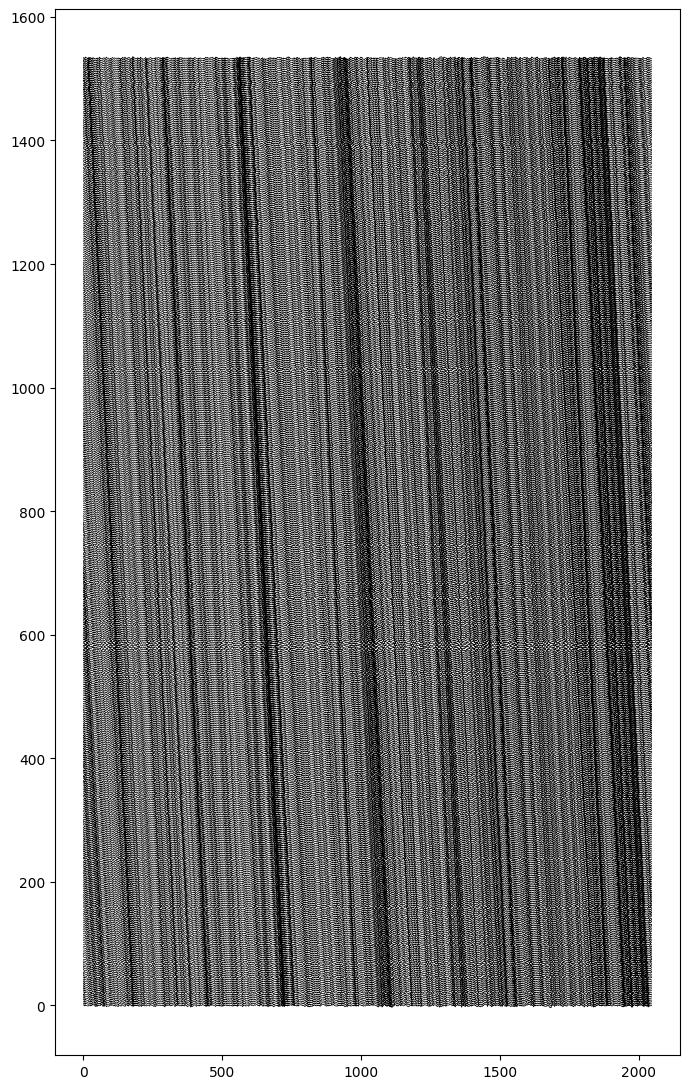

'\nfor j in range(15):\n    plt.figure(figsize=(7, 15))\n    for i in range(len(train_sr[j*100:j*100+100])):\n        sr = train_sr[j*100 + i] / train_sr[j*100 + i].std()\n        plt.plot(sr + 5*i, c="k", lw=0.5, alpha=1)\n    plt.tight_layout()\n    plt.show()\n'

In [38]:
eq_strain_rates = np.load("data/DAS/SIS-rotated_train_50Hz.npy")
eq_strain_rates = torch.tensor(eq_strain_rates)

dataset = SyntheticNoiseDAS(eq_strain_rates,512)
dataLoader = DataLoader(dataset, batch_size=4, shuffle=True)
original = next(iter(dataLoader))
"""
for j in range(4):
    plt.figure(figsize=(7, 15))
    for i in range(len(test_sr[j*100:j*100+100])):
        sr = test_sr[j*100 + i] / test_sr[j*100 + i].std()
        plt.plot(sr + 5*i, c="k", lw=0.5, alpha=1)
    plt.tight_layout()
    plt.show()
"""
print(original.shape)
original = original[0]
plt.figure(figsize=(7, 11))
for i in range(original.shape[1]):
    sr = original[0][i] / original[0][i].std()
    plt.plot(sr + 3*i, c="k", lw=0.5, alpha=1)
    #if every chanle by it self
    #plt.subplot(original.shape[1], 1, i + 1)
    #plt.plot(original[0, i].numpy(), c="k", lw=0.5, alpha=1)
    #plt.title(f'Channel {i + 1}')
    plt.tight_layout()
plt.show()

"""
for j in range(15):
    plt.figure(figsize=(7, 15))
    for i in range(len(train_sr[j*100:j*100+100])):
        sr = train_sr[j*100 + i] / train_sr[j*100 + i].std()
        plt.plot(sr + 5*i, c="k", lw=0.5, alpha=1)
    plt.tight_layout()
    plt.show()
"""

In [10]:
def n2n_create_2_input(device, methode, original, noise_images):
    if "2_input" in methode:
        if config.useSigma:
            noise_image2 = add_norm_noise(original, config.sigma, -1,-1,False)
        else:
            noise_image2, alpha = add_noise_snr(original, snr_db=config.sigmadb)
    else:
        if config.useSigma:
            noise_image2 = add_norm_noise(noise_images, config.methodes['n2noise_1_input']['secoundSigma'], -1,-1,False)
        else:
            noise_image2, alpha = add_noise_snr(noise_images, snr_db=config.methodes['n2noise_1_input']['secoundSigma']) 
    noise_image2 = noise_image2.to(device)
    return noise_image2#original, noise_images  are onlly if n2void

In [24]:
eq_strain_rates = torch.randn(10, 5000)  # Beispielhafte Daten, bitte durch Ihre eigenen Daten ersetzen

#eq_strain_rates = np.load("data/DAS/SIS-rotated_train_50Hz.npy")

dataset = SyntheticNoiseDAS(eq_strain_rates)

# Erstellen des DataLoaders
dataLoader = DataLoader(dataset, batch_size=4, shuffle=True)

methoden = ["n2noise", "n2score", "n2self", "n2self j-invariant", "n2same", "n2same batch", "n2info", "self2self", "n2void"]
#methoden = ["n2void"]
methoden = list(config.methodes.keys())
sigma = 2
mode = "train"
lambda_inv=2
dropout_rate=0
max_Predictions=100
sigma_info=1

for methode in methoden:
    print(methode)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    #model = U_Net(in_chanel=1, scaling_kernel_size=(1,2), batchNorm=True).to(device)
    model = TestNet(1,1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
    # Iterieren durch den DataLoader
    batch_idx = 0
    print(len(dataLoader))
    """
    for batch in dataLoader:
        samples, eq_das, noise, scales, amps = batch
        samples = samples.to(device).float()
        eq_das = eq_das.to(device).float()
        
        loss, denoised, original, noise_images, optional_tuples = calculate_loss(model, device, dataloader, methode, 2, noise.std(), batch_idx, eq_das, samples, augmentation=True, lambda_inv=2, dropout_rate=0.3, samples=10, num_patches_per_img=None, num_masked_pixels=8, sigma_info=1)
        batch_idx += 1
        if batch_idx%100 == 0:
            print(loss)
    """
    all_marked = 0
    for batch_idx, original in enumerate((dataLoader)):#tqdm
        original = original.to(device).dtype(torch.float32)
        batch = original.shape[0]
        if config.useSigma:
            noise_images = add_norm_noise(original, sigma, a=-1, b=1, norm=False)
            true_noise_sigma = sigma
        else:
            noise_images, true_noise_sigma = add_noise_snr(original, snr_db=sigma)
        
        noise_images = noise_images.to(device)
        if "n2noise" in methode:
            noise_images2 = n2n_create_2_input(device, methode, original, noise_images)
            if "test" in methode:
                noise_images2 = add_norm_noise(original, config.methodes['n2noise_2_input_test']['secoundSigma'], a=-1, b=1, norm=False)
            #noise_images2 = torch.clip(noise_images2, 0,1.0)
        else:
            noise_images2 = None
        #noise_images = torch.clip(noise_images, 0,1.0)

        if mode=="test" or mode =="validate":
            model.eval()
            with torch.no_grad():
                loss, _, _, _, optional_tuples = calculate_loss(model, device, dataLoader, methode, true_noise_sigma, batch_idx, original, noise_images, noise_images2, augmentation=False, dropout_rate=dropout_rate)
                (_, _, _, est_sigma_opt) = optional_tuples
                if "n2noise" in methode:
                    denoised = model (noise_images)            
                elif "n2score"  in methode:
                    #true_sigma_score.append(true_noise_sigma)
                    vector =  model(noise_images)
                    best_tv, best_sigma = evaluateSigma(noise_images, vector)
                    #best_sigmas.append(best_sigma)
                    #all_tvs.append(best_tv)
                    denoised = noise_images + best_sigma**2 * vector
                elif "n2self" in methode:
                    #if "j-invariant" in methode:
                    if "j-invariant" in config.methodes[methode]['erweiterung']:
                        denoised = Mask.n2self_jinv_recon(noise_images, model)
                    else:
                        denoised = model(noise_images)
                elif "n2same" in methode:
                    denoised = model(noise_images)
                elif "n2void" in methode:
                    #calculate mean and std for each Image in batch in every chanal
                    #mean = noise_images.mean(dim=[0,2,3])
                    #std = noise_images.std(dim=[0,2,3])
                    #noise_images = (noise_images - mean[None, :, None, None]) / std[None, :, None, None]
                    noise_images = (noise_images - noise_images.mean(dim=(1, 2), keepdim=True)) / noise_images.std(dim=(1, 2), keepdim=True)
                    denoised = model(noise_images)
                elif "s2self" in methode:
                    denoised = torch.ones_like(noise_images)
                    for i in range(max_Predictions):
                        _, denoised_tmp, _, _, flip = calculate_loss(model, device, dataLoader, methode, true_noise_sigma, batch_idx, original, noise_images, noise_images2, augmentation, dropout_rate=dropout_rate)
                        (lr, ud, _, _) = flip
                        #denoised_tmp = filp_lr_ud(denoised_tmp, lr, ud)
                        denoised = denoised + denoised_tmp
                    denoised = denoised / max_Predictions
                    denoised = (denoised+1)/2
                elif "n2info" in methode:
                    #TODO: normalisierung ist in der implementation da, aber ich habe es noch nicht im training gefunden
                    if mode=="test":
                        denoised = model(noise_images)
                    else:
                        #loss, denoised, loss_rec, loss_inv, marked_pixel = n2same(noise_images, device, model, lambda_inv)
                        loss, denoised, loss_rec, loss_inv, marked_pixel = n2info(noise_images, model, device, sigma_info)
                        all_marked += marked_pixel
                        lex += loss_rec
                        lin += loss_inv
                        n_partition = (denoised-noise_images).view(denoised.shape[0], -1) # (b, c*w*h)
                        n_partition = torch.sort(n_partition, dim=1).values #descending=False
                        n = torch.cat((n, n_partition), dim=0)
                        if batch_idx == len(dataLoader)-1:
                            e_l = 0
                            for i in range(config.methodes['n2info']['predictions']): #kmc
                                #to big for torch.multinomial if all pictures from validation should be used
                                #samples = torch.tensor(torch.multinomial(n.view(-1), n.shape[1], replacement=True))#.view(1, n.shape[1])
                                #samples = torch.sort(samples).values
                                samples = np.sort(np.random.choice((n.cpu()).reshape(-1),[1, n.shape[1]])) #(1,49152)
                                e_l += torch.mean((n-torch.from_numpy(samples).to(device))**2)
                            lex = lex / (len(dataLoader) * denoised.shape[0])
                            lin = lin / all_marked
                            e_l = e_l / config.methodes['n2info']['predictions']
                            #estimated_sigma = (lin)**0.5 + (lin + lex-e_l)**0.5 #inplementation from original github of noise2info
                            m = len(dataLoader) * denoised.shape[0] *3*128*128 #TODO: is m right?
                            estimated_sigma = lex + (lex**2 * m *(lin-e_l))**0.5/m #from paper
                            print('new sigma_loss is ', estimated_sigma)
                            if 0 < estimated_sigma < sigma_n:
                                sigma_n = float(estimated_sigma)
                                print('sigma_loss updated to ', estimated_sigma)
                        
        else:
            model.train()
            #original, noise_images are only important if n2void
            loss, denoised, original, noise_images, optional_tuples = calculate_loss(model, device, dataLoader, methode, true_noise_sigma, batch_idx, original, noise_images, noise_images2, augmentation=False, dropout_rate=dropout_rate, sigma_info=sigma_info)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #if config.methodes[methode]['sheduler']:
                #scheduler.step()

        #log Data
        denoised = (denoised-denoised.min())  / (denoised.max() - denoised.min())
        
        original = (original-original.min())  / (original.max() - original.min())
        psnr_batch = Metric.calculate_psnr(original, denoised)
        #similarity_batch, diff_picture = Metric.calculate_similarity(original, denoised)
        
        if batch_idx%100 == 0:
            print(loss)
            print(psnr_batch)
            print()
            
        """
        DAS-syntttetische  Datten

        noise -> NaN
        score -> 0,99  27.4
        self ->  0,05  26,19
        self_j -> 0,05  25,69
        same -> 0,53  27,76
        same_b -> 0,52  27,44
        info -> 0,64  27,79
        self2self -> Probleme
        n2void -> Probbleme
        """

n2noise_2_input
250


C:\Users\LaAlexPi\AppData\Local\Temp\ipykernel_16620\2902701896.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample[i] = torch.roll(strain_rate, int(i*shift + np.random.randn(1)))


TypeError: 'torch.dtype' object is not callable